In [1]:
import cv2
import pandas
from pathlib import Path 
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.image import img_to_array
import tensorflow as tf
tf.__version__

from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input

import warnings
warnings.filterwarnings('ignore')

2024-06-02 14:43:51.906033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:43:51.906174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:43:52.086564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# sns.set_style('darkgrid')
# plt.style.use("dark_background")
# plt.rcParams['figure.facecolor'] = 'black'

In [3]:
data_dir = Path('/kaggle/input/laststretch/captcha10')
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 1500
Number of labels found: 1500
Number of unique characters: 62
Characters present: {'Z', 'O', 'U', 'V', 't', 'B', 'n', 'z', 'a', 'S', 'e', '5', 'u', 's', 'l', 'F', 'm', '8', 'I', 'v', 'Y', 'R', 'G', 'k', 'H', '4', 'w', 'T', 'q', 'J', 'g', 'y', 'o', '0', 'L', 'p', '6', 'N', 'K', 'b', 'Q', 'E', 'W', '9', 'D', 'M', '2', 'c', 'h', '7', '3', 'x', 'r', 'f', 'X', 'A', 'C', 'j', 'i', 'P', '1', 'd'}


In [4]:
def plot(img):
    plt.imshow(img, 'gray')
    plt.axis('off')

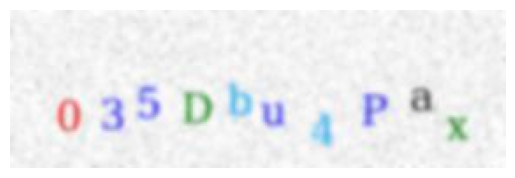

In [5]:
img = cv2.imread('/kaggle/input/laststretch/captcha10/035Dbu4Pax.jpg')
plot(img)

In [6]:
height, width, channels = img.shape
print("Image size: {} x {} pixels".format(width, height))
print("Number of channels: {}".format(channels))

Image size: 282 x 90 pixels
Number of channels: 3


## Image processing

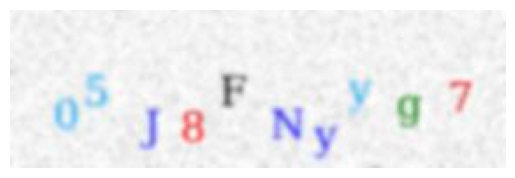

In [7]:
img = cv2.imread('/kaggle/input/laststretch/captcha10/05J8FNyyg7.jpg')
plot(img)

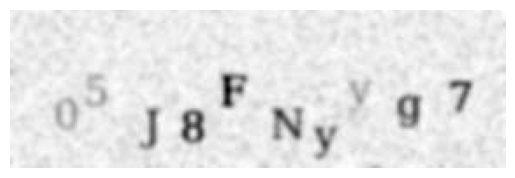

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plot(img)

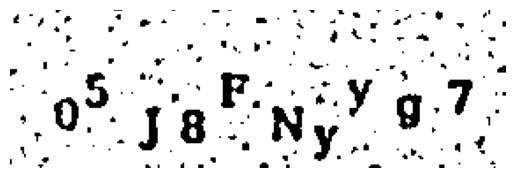

In [9]:
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 7)
plot(img)

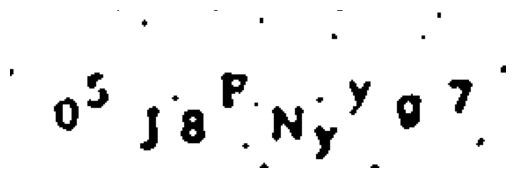

In [10]:
img= cv2.medianBlur(img, 5)
plot(img)

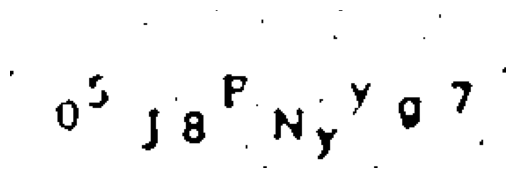

In [11]:
img = cv2.dilate(img, np.ones((2, 2), np.uint8))
plot(img)

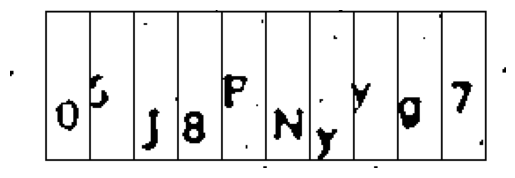

In [12]:
# img = cv2.imread('/kaggle/input/captcha-images/00PbR0cxrC.jpg')
d = cv2.rectangle(img, (20,1), (45,85), 0, 1)
cv2.rectangle(d, (45,1), (70,85), 0, 1)
cv2.rectangle(d, (70,1), (95,85), 0, 1)
cv2.rectangle(d, (95,1), (120,85), 0, 1)
cv2.rectangle(d, (120,1), (145,85), 0, 1)
cv2.rectangle(d, (145,1), (170,85), 0, 1)
cv2.rectangle(d, (170,1), (195,85), 0, 1)
cv2.rectangle(d, (195,1), (220,85), 0, 1)
cv2.rectangle(d, (220,1), (245,85), 0, 1)
cv2.rectangle(d, (245,1), (270,85), 0, 1)
plot(d)

## 20 45 70 95 120 145 170 195 220 245 270

In [13]:
X = []
y = []

path = ('/kaggle/input/laststretch/captcha10')

for image in os.listdir(path) :
    
    if image[11:] != 'jpg' :
        continue
    
    img = cv2.imread(os.path.join(path, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 7)
    img = cv2.medianBlur(img, 5)
    img = cv2.dilate(img, np.ones((2, 2), np.uint8))
#     img = cv2.erode(img, np.ones((3, 3), np.uint8))
#     img = cv2.dilate(img, np.ones((3, 2), np.uint8))
    
    
    image_list = [img[0:85, 20:45], img[0:85, 45:70], img[0:85, 70:95], img[0:85, 95:120], img[0:85, 120:145],
                  img[0:85, 145:170], img[0:85, 170:195], img[0:85, 195:220], img[0:85, 220:245], img[0:85, 245:270]]
    
    for i in range(10) :
        X.append(img_to_array(Image.fromarray(image_list[i])))
        y.append(image[i])
        
X = np.array(X)
y = np.array(y)

In [14]:
print(f'shape of X: {X.shape}\nshape of y: {y.shape}')

shape of X: (15000, 85, 25, 1)
shape of y: (15000,)


## Data analysis

In [15]:
temp = set(y)

In [16]:
temp_df = pandas.DataFrame({'labels' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})

Text(0.5, 1.0, 'Label distribution in captcha')

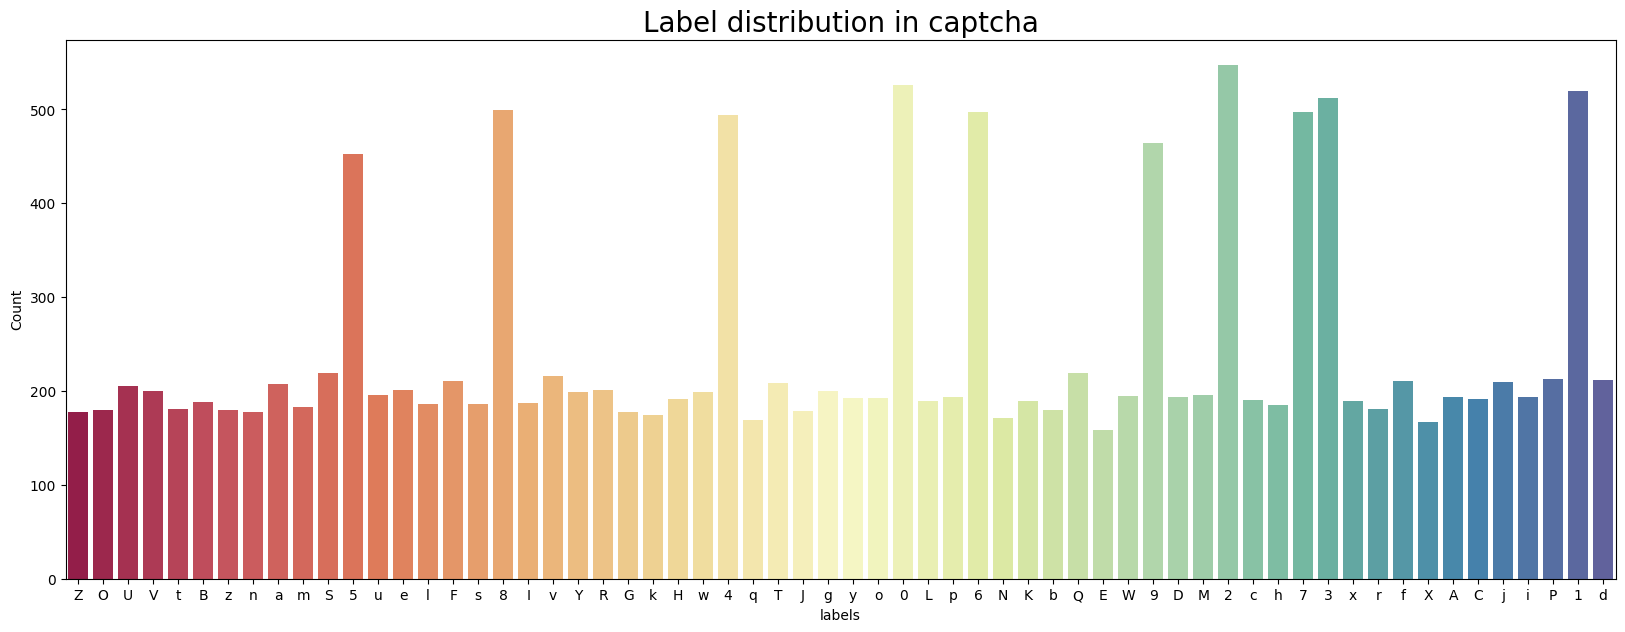

In [17]:
plt.figure(figsize = (20,7))
sns.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Spectral')
plt.title('Label distribution in captcha', fontsize = 20)

[]

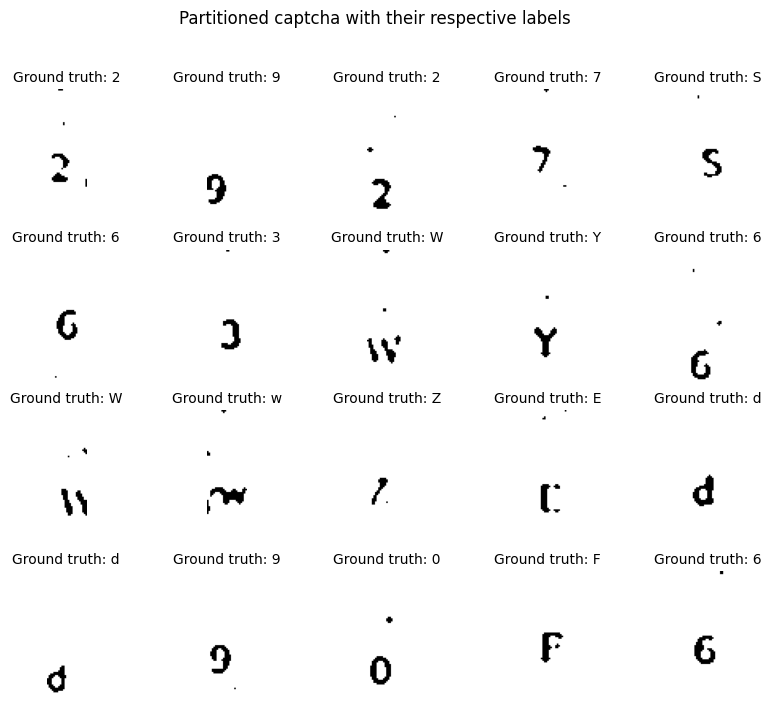

In [18]:
plt.figure(figsize = (10,8))
for i in range(20) :
    plt.subplot(4,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.axis('off')
    plt.title(f'Ground truth: {str(y[i])}', fontsize = 10)
plt.suptitle('Partitioned captcha with their respective labels')
plt.plot()

## Label encoding

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse_output = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [20]:
info = {y_combine[i] : y[i] for i in range(len(y))}

## Train test split

In [21]:
print(X.shape)
print(y_one_hot.shape)

(15000, 85, 25, 1)
(15000, 62)


In [22]:
X_train, x_test, Y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.1, random_state = 42)

In [23]:
print(f'X_train shape: {X_train.shape}\nY_train shape: {Y_train.shape}\nx_test shape: {x_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (13500, 85, 25, 1)
Y_train shape: (13500, 62)
x_test shape: (1500, 85, 25, 1)
y_test shape: (1500, 62)


### Accounting for data imbalance with oversampling

In [24]:
X_train = np.reshape(X_train, (13500, 85*25))

In [25]:
from imblearn.over_sampling import SMOTE # Synthetic Minority Over-sampling Technique
X_train, Y_train = SMOTE(sampling_strategy = 'auto', random_state = 42).fit_resample(X_train, Y_train)

In [26]:
print(f'X_train shape: {X_train.shape}\nY_train shape: {Y_train.shape}')

X_train shape: (31062, 2125)
Y_train shape: (31062, 62)


In [27]:
X_train = np.reshape(X_train, (31062, 85, 25, 1))

## Model compilation

In [28]:
def convolutional_layer(x) :
    model = Sequential()
    
    model.add(Conv2D(x, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model

In [29]:
def dense_layer(y) :
    model = Sequential()
    
    model.add(Dense(y, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [30]:
def cnn(a, b, c, d, e, f):
    model = Sequential()
    model.add(Input((85,25,1)))
    
    model.add(convolutional_layer(a))
    model.add(convolutional_layer(b))
    model.add(convolutional_layer(c))
    model.add(convolutional_layer(d))
    
    model.add(Flatten())
    
    model.add(dense_layer(e))
    model.add(dense_layer(f))
    
    model.add(Dense(62, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [31]:
model = cnn(16, 16, 32, 32, 1024, 128) #còn p test lại
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 43, 13, 16)     │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 22, 7, 16)      │         2,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 11, 4, 32)      │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 6, 2, 32)       │         9,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 1024)           │       398,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 128)            │       131,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,798 (2.12 MB)

 Trainable params: 552,302 (2.11 MB)

 Non-trainable params: 2,496 (9.75 KB)

### ModelCheckpoint and ReduceLROnPlateau
ModelCheckpoint - retain the best performing model in terms of loss https://keras.io/api/callbacks/model_checkpoint/

ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

In [32]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('models/best_model.keras', monitor = 'val_accuracy', verbose = 1, save_best_only = True) 

In [33]:
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1)

In [34]:
history = model.fit(X_train, Y_train, batch_size = 16, validation_data = (x_test, y_test), epochs = 20, steps_per_epoch = int(len(X_train)/32), callbacks = [checkp, reduce])

Epoch 1/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1154 - loss: 3.7550
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to models/best_model.keras
970/970 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - accuracy: 0.1155 - loss: 3.7541 - val_accuracy: 0.5833 - val_loss: 1.4148 - learning_rate: 0.0010
Epoch 2/20
969/970 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6483 - loss: 1.1249
Epoch 2: val_accuracy improved from 0.58333 to 0.68600, saving model to models/best_model.keras
970/970 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.6484 - loss: 1.1246 - val_accuracy: 0.6860 - val_loss: 1.0107 - learning_rate: 0.0010
Epoch 3/20
  1/970 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - accuracy: 0.7500 - loss: 0.9057
Epoch 3: val_accuracy did not improve from 0.68600
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7273 - loss: 0.8020 - val_accuracy: 0.6567 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 4/20
969/970 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7892

Text(0.5, 1.0, 'Model accuracy by Epoch')

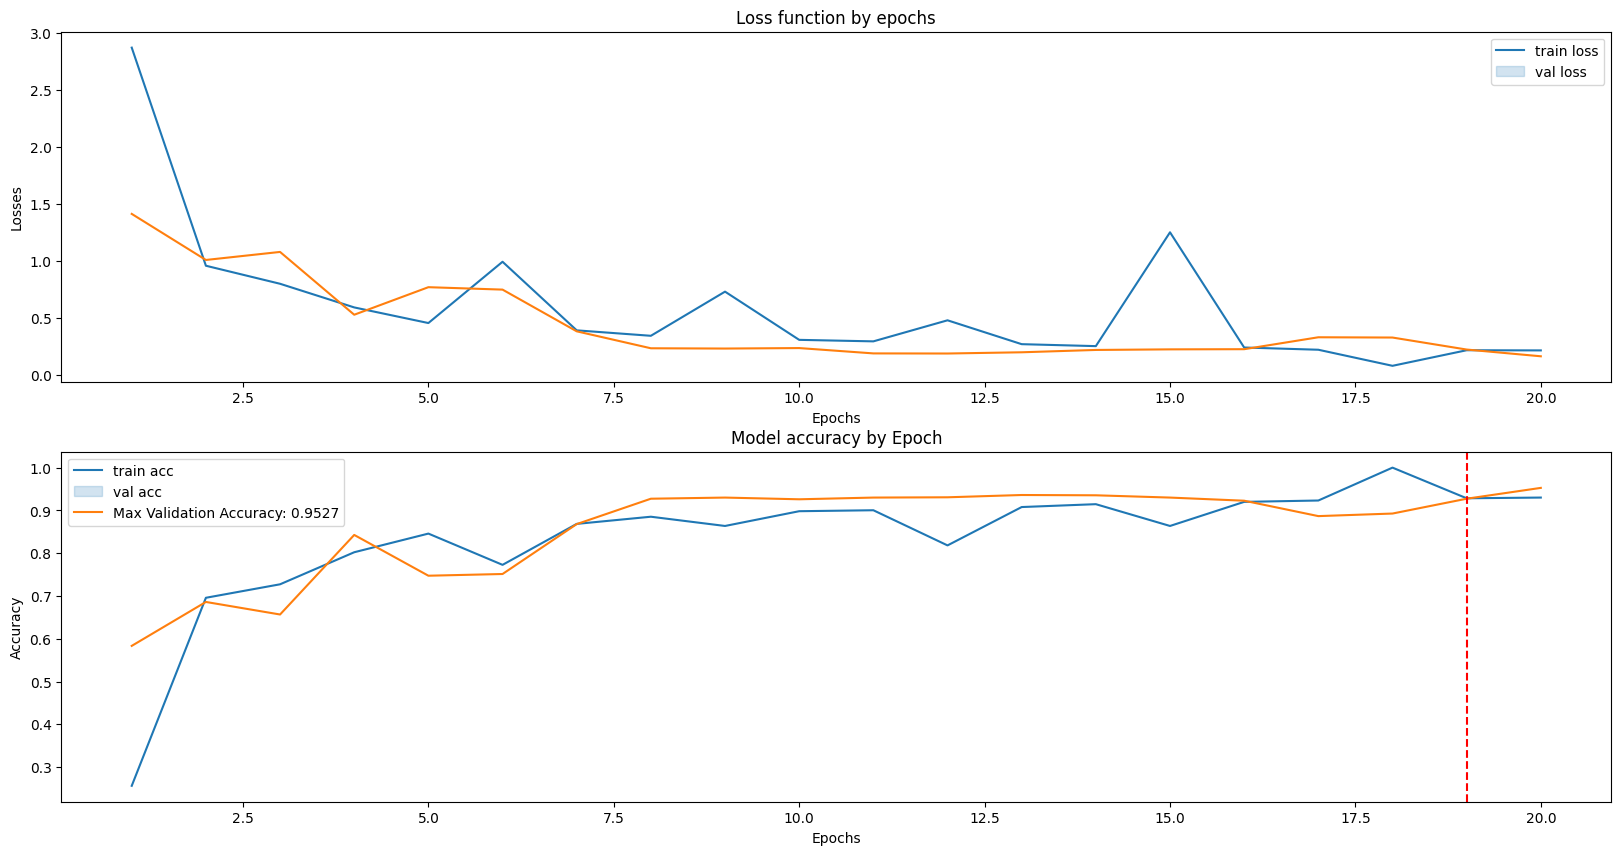

In [35]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'])
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss', 'val loss'])
plt.title('Loss function by epochs')

plt.subplot(2, 1, 2)
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'])
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
max_val_acc = max(history.history['val_accuracy'])
plt.axvline(x=history.history['val_accuracy'].index(max_val_acc), color='red', linestyle='--')
plt.legend(['train acc', 'val acc', f'Max Validation Accuracy: {max_val_acc:.4f}'])
plt.title('Model accuracy by Epoch')

In [36]:
model = load_model('models/best_model.keras')

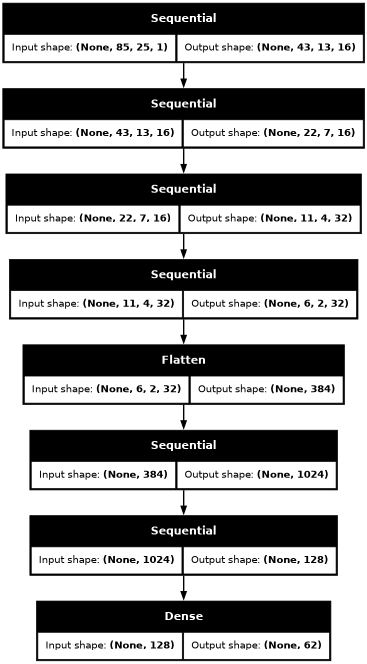

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='model_visualization.png', show_shapes=True, dpi=50)

In [38]:
pred = model.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [39]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)

In [40]:
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [41]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.9526666666666667
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        64
           1       0.95      0.82      0.88        51
           2       1.00      0.98      0.99        46
           3       0.96      0.98      0.97        54
           4       1.00      0.96      0.98        49
           5       0.98      0.98      0.98        43
           6       0.98      1.00      0.99        50
           7       1.00      0.98      0.99        56
           8       1.00      0.98      0.99        65
           9       0.98      0.86      0.92        51
           A       1.00      1.00      1.00        22
           B       1.00      1.00      1.00        19
           C       1.00      1.00      1.00        19
           D       1.00      1.00      1.00        18
           E       1.00      0.92      0.96        13
           F       0.92      0.85      0.88        13
           G       1.00      1.00      1.00        

In [42]:
a =32
b = 64
c = 32
d= 64

def cnn(hp):
    model = Sequential()
    model.add(Input((85,25,1)))

    model.add(Conv2D(a, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.2)))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(c, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.2)))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(b, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.2)))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(d, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())

    hp_layer_1 = hp.Int('layer_1', min_value=200, max_value=1000, step=150)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=200, step=150)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    hp_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Tune the learning rate for each optimizer
    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate_adam', [1e-2, 1e-3, 1e-4]))
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate_rmsprop', [1e-2, 1e-3, 1e-4]))
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate_sgd', [1e-2, 1e-3, 1e-4]))


    model.add(Dense(hp_layer_1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.2)))

    model.add(Dense(hp_layer_2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.2)))

    model.add(Dense(62, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [43]:
import keras_tuner as kt
tuner = kt.Hyperband(cnn,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='dir',
                     project_name='we_gon_win')

In [ ]:
tuner.search(X_train, Y_train,
             epochs=30,
             batch_size=24,
             validation_data=(x_test, y_test),
             steps_per_epoch=int(len(X_train)/32),
             callbacks=[checkp, reduce]   #check and reduce are below
            )

Trial 7 Complete [00h 01m 53s]
val_accuracy: 0.024000000208616257

Best val_accuracy So Far: 0.9133333563804626
Total elapsed time: 00h 14m 36s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
0.5               |0.1               |dropout_3
500               |950               |layer_1
182               |32                |layer_2
0.001             |0.0001            |learning_rate
rmsprop           |adam              |optimizer
0.01              |0.001             |learning_rate_adam
0.0001            |0.01              |learning_rate_rmsprop
0.001             |None              |learning_rate_sgd
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
520/970 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.0209 - loss: 5.3737